<h1>Содержание<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Загрузка-данных" data-toc-modified-id="Загрузка-данных-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Загрузка данных</a></span><ul class="toc-item"><li><span><a href="#Вывод" data-toc-modified-id="Вывод-1.1"><span class="toc-item-num">1.1&nbsp;&nbsp;</span>Вывод</a></span></li></ul></li><li><span><a href="#Анализ" data-toc-modified-id="Анализ-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Анализ</a></span><ul class="toc-item"><li><span><a href="#Скользящее-среднее" data-toc-modified-id="Скользящее-среднее-2.1"><span class="toc-item-num">2.1&nbsp;&nbsp;</span>Скользящее среднее</a></span></li><li><span><a href="#Тренды-и-сезонность" data-toc-modified-id="Тренды-и-сезонность-2.2"><span class="toc-item-num">2.2&nbsp;&nbsp;</span>Тренды и сезонность</a></span></li><li><span><a href="#Стационарные-ряды-и--разности-временного-ряда" data-toc-modified-id="Стационарные-ряды-и--разности-временного-ряда-2.3"><span class="toc-item-num">2.3&nbsp;&nbsp;</span>Стационарные ряды и  разности временного ряда</a></span></li><li><span><a href="#Вывод" data-toc-modified-id="Вывод-2.4"><span class="toc-item-num">2.4&nbsp;&nbsp;</span>Вывод</a></span></li></ul></li><li><span><a href="#Обучение" data-toc-modified-id="Обучение-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Обучение</a></span><ul class="toc-item"><li><span><a href="#Создание-признаков" data-toc-modified-id="Создание-признаков-3.1"><span class="toc-item-num">3.1&nbsp;&nbsp;</span>Создание признаков</a></span></li><li><span><a href="#Подготовка-данных-к-обучению" data-toc-modified-id="Подготовка-данных-к-обучению-3.2"><span class="toc-item-num">3.2&nbsp;&nbsp;</span>Подготовка данных к обучению</a></span></li><li><span><a href="#Подбор-гипперпараметров-для-моделей-обучения-и-выбор-модели" data-toc-modified-id="Подбор-гипперпараметров-для-моделей-обучения-и-выбор-модели-3.3"><span class="toc-item-num">3.3&nbsp;&nbsp;</span>Подбор гипперпараметров для моделей обучения и выбор модели</a></span></li><li><span><a href="#CatBoost" data-toc-modified-id="CatBoost-3.4"><span class="toc-item-num">3.4&nbsp;&nbsp;</span>CatBoost</a></span></li><li><span><a href="#LightGBM" data-toc-modified-id="LightGBM-3.5"><span class="toc-item-num">3.5&nbsp;&nbsp;</span>LightGBM</a></span></li><li><span><a href="#LinearRegression" data-toc-modified-id="LinearRegression-3.6"><span class="toc-item-num">3.6&nbsp;&nbsp;</span>LinearRegression</a></span></li><li><span><a href="#Анализ-моделей" data-toc-modified-id="Анализ-моделей-3.7"><span class="toc-item-num">3.7&nbsp;&nbsp;</span>Анализ моделей</a></span></li></ul></li><li><span><a href="#Тестирование" data-toc-modified-id="Тестирование-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Тестирование</a></span></li><li><span><a href="#Вывод" data-toc-modified-id="Вывод-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>Вывод</a></span></li></ul></div>

#  Прогнозирование заказов такси

Компания «Чётенькое такси» собрала исторические данные о заказах такси в аэропортах. Чтобы привлекать больше водителей в период пиковой нагрузки, нужно спрогнозировать количество заказов такси на следующий час. Построим модель для такого предсказания.

Значение метрики *RMSE* на тестовой выборке должно быть не больше 48.

Нам нужно:

1. Загрузить данные и выполнить их ресемплирование по одному часу.
2. Проанализировать данные.
3. Обучить разные модели с различными гиперпараметрами. Сделать тестовую выборку размером 10% от исходных данных.
4. Проверить данные на тестовой выборке и сделать выводы.


Данные лежат в файле `taxi.csv`. Количество заказов находится в столбце `num_orders` (от англ. *number of orders*, «число заказов»).

## Загрузка данных

In [1]:
# установка модулей
# !pip3 install lightgbm
# !pip3 install optuna
# !pip3 install featuretools
# !pip install catboost

In [2]:
# импортируем библиотеки дляя работы
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from statsmodels.tsa.seasonal import seasonal_decompose
import time

import lightgbm as lgb
from sklearn.model_selection import train_test_split
from sklearn.model_selection import TimeSeriesSplit
from catboost import CatBoostRegressor
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import GridSearchCV
from catboost import Pool, cv
from sklearn.metrics import accuracy_score
from scipy.signal import find_peaks

import optuna
from optuna.visualization import plot_optimization_history, plot_param_importances

pd.set_option('display.max_columns', None)

In [3]:
# ft.primitives.list_primitives()

In [4]:
# загрузка данных индексы заменим датой, при этом сразу измекним тип данных на datetime
df = pd.read_csv('taxi.csv', index_col=[0], parse_dates=[0])
# сортировка индексов
df.sort_index(inplace=True)
# вывод 5 строк
df.head()

,num_orders
datetime,
2018-03-01 00:00:00,9
2018-03-01 00:10:00,14
2018-03-01 00:20:00,28
2018-03-01 00:30:00,20
2018-03-01 00:40:00,32


In [5]:
# выведем общую информацию по датасету
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 26496 entries, 2018-03-01 00:00:00 to 2018-08-31 23:50:00
Data columns (total 1 columns):
 #   Column      Non-Null Count  Dtype
---  ------      --------------  -----
 0   num_orders  26496 non-null  int64
dtypes: int64(1)
memory usage: 414.0 KB


In [6]:
# проверим возрастание по индексу (сортировка), если True - то все верно
df.index.is_monotonic

True

In [7]:
df.describe()

,num_orders
count,26496.000000
mean,14.070463
std,9.211330
min,0.000000
25%,8.000000
50%,13.000000
75%,19.000000
max,119.000000


`num_orders` - кол-во заказов  
Пропущенных значений в данных нет. 
Данные имеют шаг по 10 минут. Выполним их ресемплирование по одному часу.

In [8]:
# ресемплирование
df = df.resample('1H').sum()
# вывод 5 строк для проверки
df.head()

,num_orders
datetime,
2018-03-01 00:00:00,124
2018-03-01 01:00:00,85
2018-03-01 02:00:00,71
2018-03-01 03:00:00,66
2018-03-01 04:00:00,43


### Вывод

Мы загрузили данные, предварительно заменив индексы на datetime.  
В нашем распоряжении 26496 записей. Данные с 2018-03-01 по 2018-08-31 за каждые 10 минут.  
Выполнили ресемплирование по одному часу.

## Анализ

Проверим на выбросы наш датасет.

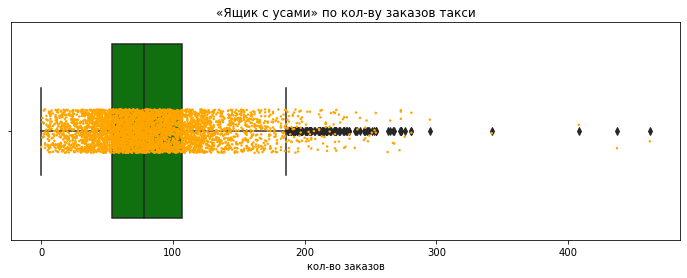

In [9]:
plt.figure(figsize=(12,4))
ax = sns.boxplot(x='num_orders', data=df, color="green")

ax = sns.stripplot(x='num_orders', data=df
                   , color="orange", jitter=1, size=2.5)
plt.title('«Ящик с усами» по кол-ву заказов такси')
plt.xlabel('кол-во заказов');

В данных есть выбросы, пока ничего с ними делать не будем.

### Скользящее среднее

Чтобы во временном ряду снизить колебания, применим скользящее среднее.

**Скользящее среднее**, или движущееся среднее — метод сглаживания временных рядов. Его суть заключается в поиске значений, которые меньше всего подвержены колебаниям, то есть средних арифметических.

In [10]:
# напишем функцию для построения графиков
def plot_rolling_mean(df, win_n):

    rolling_mean = df.rolling(window=win_n).mean()
    plt.figure(figsize=(16,6))
    plt.title(f'Заказы такси со скользящим средним = {win_n}')
    plt.plot(rolling_mean, "g", label="Скользящее среднее")
    plt.plot(df[win_n:], label="Кол-во заказов", alpha=.5)
    plt.legend(loc="upper left")

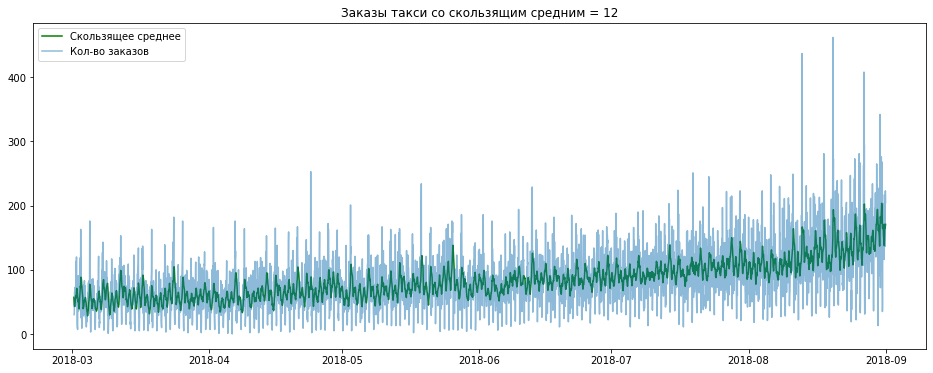

In [11]:
plot_rolling_mean(df, 12)

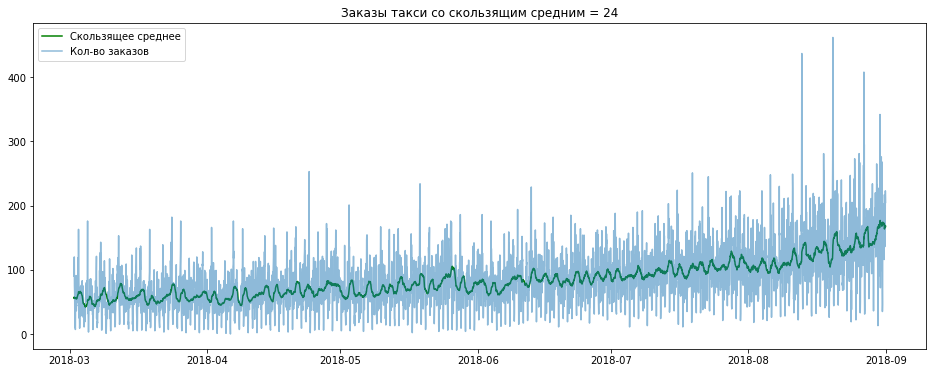

In [12]:
plot_rolling_mean(df, 24)

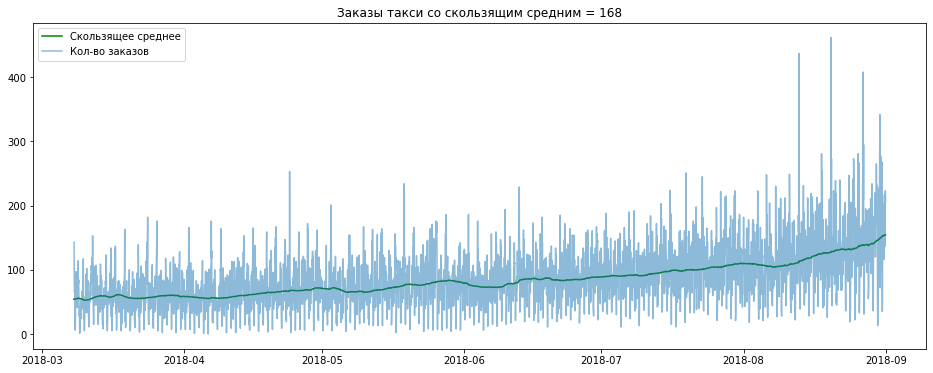

In [13]:
plot_rolling_mean(df, 168)

Есть сигналы (пики) к увеличению кол-ва машин в определенное время, на скользящем среднем мы их тоже видим. Проведем позже дополнительный анализ, т.к. делать какие-то серьезные выводы из полученных графиков не стоит.

### Тренды и сезонность

Чтобы лучше понимать временной ряд, разберём тренды и сезонность.  
**Тренд** — плавное изменение среднего значения ряда без повторяющихся закономерностей. Например: ежегодное увеличение объёма продаж.  
**Сезонность** — циклично повторяющиеся закономерности во временном ряду. Допустим, рост продаж санок зимой.

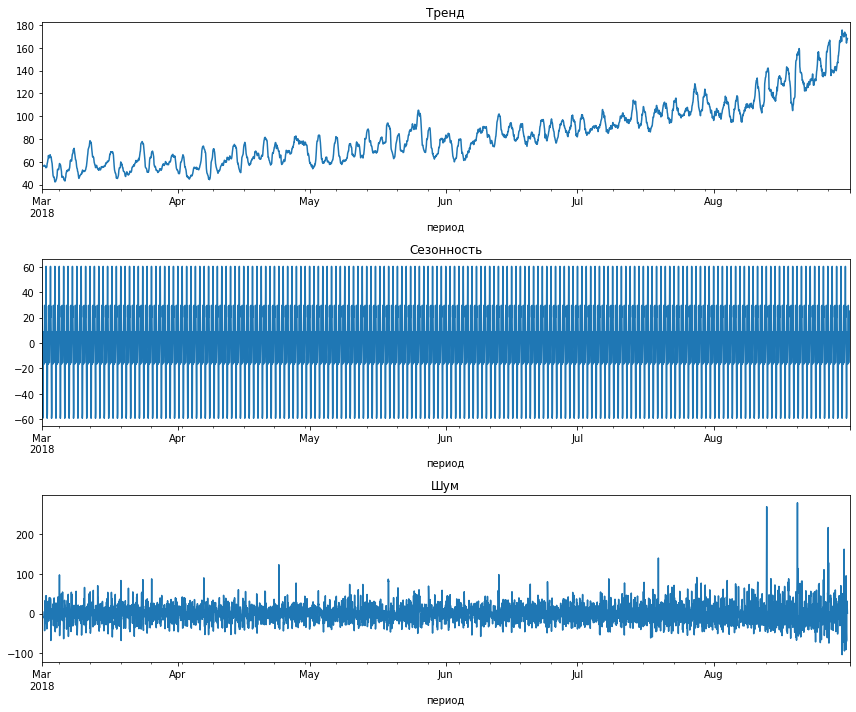

In [14]:
# раскладываем временной ряд на три составляющие: тренд, сезонность и остаток (шум)
decomposed = seasonal_decompose(df['num_orders']) 

# строим графики
plt.figure(figsize=(12, 10))
plt.subplot(311)
decomposed.trend.plot(ax=plt.gca())
plt.title('Тренд')
plt.xlabel('период')

plt.subplot(312)
decomposed.seasonal.plot(ax=plt.gca())
plt.title('Сезонность')
plt.xlabel('период')

plt.subplot(313)
decomposed.resid.plot(ax=plt.gca()) 
plt.title('Шум')
plt.xlabel('период')
plt.tight_layout()

Тренд и сезонность зависят от масштаба данных. Нельзя увидеть закономерности, повторяющиеся каждое лето, если есть данные только за год. Тренд восходящий. 

Дополнительно посмотрим график сезонности внутри суток.

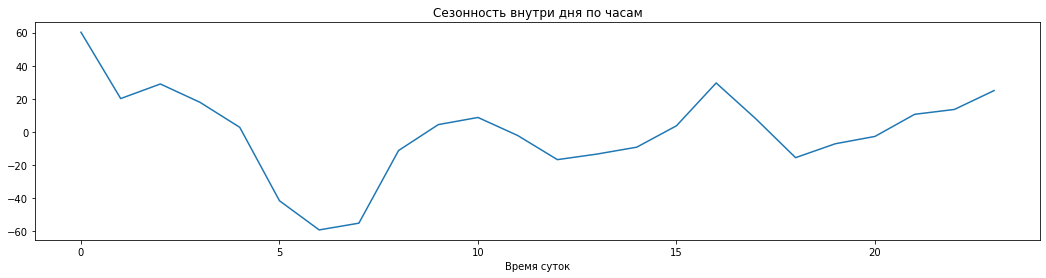

In [15]:
daily = pd.DataFrame(decomposed.seasonal['2018-05-15':'2018-05-25'])
daily['hour'] = daily.index.hour

plt.figure(figsize=(18,4))
plt.plot(daily.groupby('hour').mean())
plt.title('Сезонность внутри дня по часам')
plt.xlabel('Время суток')
plt.show();

Закономерность наблюдается по времени суток, с полуночи наблюдается спад заказов, с 6 утра наблюдается рост.

Построим график сезонности внутри недели.

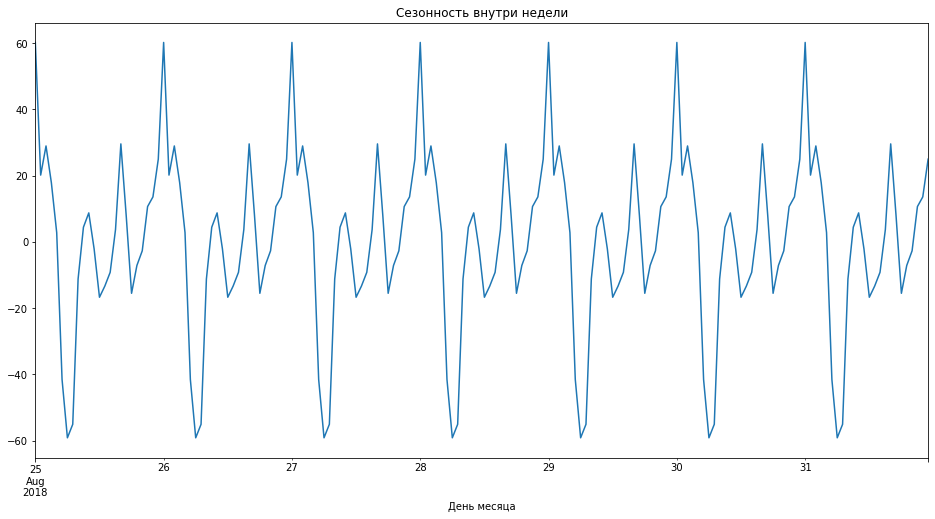

In [16]:
decomposed.seasonal.tail(24*7).plot(title='Сезонность понедельно', figsize=(16, 8))
plt.title('Сезонность внутри недели')
plt.xlabel('День месяца')
plt.show();

Какой-то явной закономерности внутри недели не наблюдается.

### Стационарные ряды и  разности временного ряда

Прогнозировать данные помогают стационарные ряды. Процесс стационарный, если его распределение со временем не меняется. Например: к такому процессу относятся периодические колебания значений. Узнать распределение временного ряда нельзя. Поэтому стационарные временные ряды — это ряды, у которых среднее и стандартное отклонение не меняются. Когда среднее и стандартное отклонение первого ряда меняется медленнее второго, то первый ряд «более стационарный», чем второй.  
Чтобы ряд сделать стационарным, найдём разности его значений. Разности временного ряда — это набор разностей между соседними элементами временного ряда, т. е. из каждого значения вычитается предыдущее.

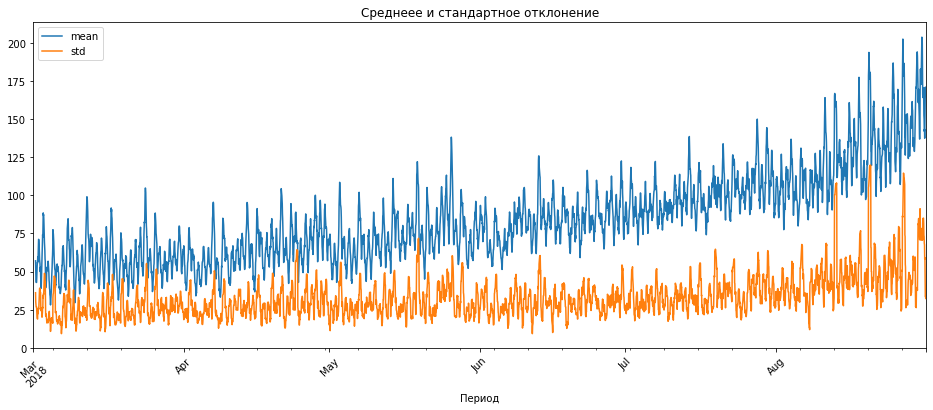

In [17]:
df['mean'] = df['num_orders'].rolling(12).mean()
df['std'] = df['num_orders'].rolling(12).std()
df[['mean', 'std']].plot(kind='line', style='-', figsize=(16,6), rot=45)
plt.title('Среднеее и стандартное отклонение')
plt.xlabel('Период');

Наблюдаем рост стандартного отклонения в августе, и рост среднего с июня. Построим разницу ряда.

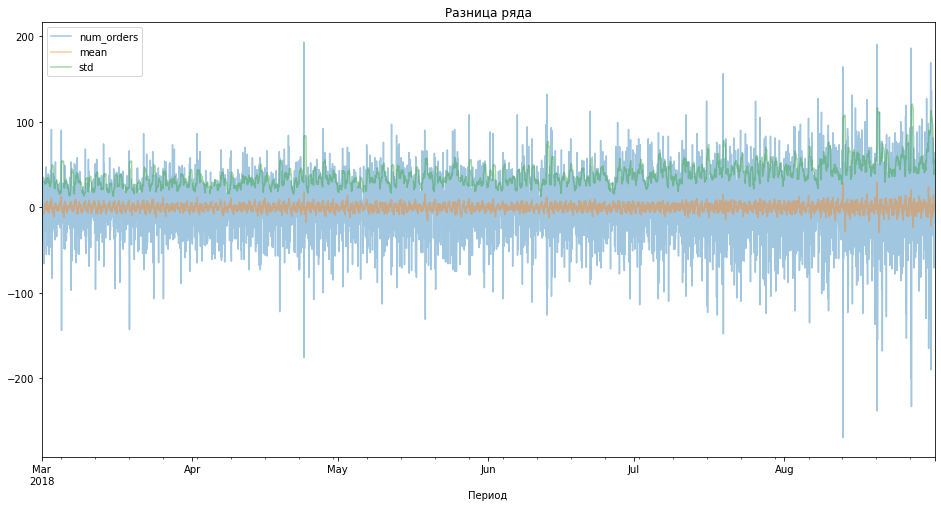

In [18]:
# сделаем копию датасета, чтобы не перезаписывать исхдные данные
df_copy = df.copy()
plt.figure(figsize=(16, 8))
# вычисляем разность ряда
df_copy['num_orders'] = df_copy['num_orders'].diff()
df_copy['mean'] = df_copy['num_orders'].rolling(12).mean()
df_copy['std'] = df_copy['num_orders'].rolling(12).std()
df_copy.plot(ax=plt.gca(), alpha=.42)
plt.title('Разница ряда')
plt.xlabel('Период')
plt.show();

Ряд выглядит более стационарным, за исключением периодов в августе, удалим вспомогательные признаки, которые были созданы. Начнем подготовку к обучению.

In [19]:
df = df[['num_orders']]
df.head()

,num_orders
datetime,
2018-03-01 00:00:00,124
2018-03-01 01:00:00,85
2018-03-01 02:00:00,71
2018-03-01 03:00:00,66
2018-03-01 04:00:00,43


### Вывод

Есть сезонность связанная со веременем суток, проверили разницу ряда, она стационарная, данные можно прогнозировать.

## Обучение

Перед обучением подготовим признаки.

### Создание признаков

Добавим календарные признаки в наш датасет, месяц, день, час, день недели.

In [20]:
df['month'] = df.index.month
df['day'] = df.index.day
df['hour'] = df.index.hour
df['dayofweek'] = df.index.dayofweek
df.head()

,num_orders,month,day,hour,dayofweek
datetime,,,,,
2018-03-01 00:00:00,124,3,1,0,3
2018-03-01 01:00:00,85,3,1,1,3
2018-03-01 02:00:00,71,3,1,2,3
2018-03-01 03:00:00,66,3,1,3,3
2018-03-01 04:00:00,43,3,1,4,3


Предыдущие значения временного ряда подскажут, будет ли функция x(t) расти или уменьшаться. Получим отстающие значения знакомой функцией shift(). Скользящее среднее как признак задаёт общий тренд временного ряда. Вычисление скользящего среднего не должно включать в себя текущее значение ряда.

In [21]:
for lag in range(1, 5):
    df['lag_{}'.format(lag)] = df['num_orders'].shift(lag)
df['rolling_mean'] = df['num_orders'].shift().rolling(4).mean()
# признак сезонности
df['seasonal'] = seasonal_decompose(df['num_orders'], extrapolate_trend='freq', period=24).seasonal
# признак тренда
df['trend'] = seasonal_decompose(df['num_orders'], extrapolate_trend='freq', period=24).trend
# признак скользящего окна (среднее)
df['expanding_window'] = df['num_orders'].expanding(24).mean()
# признак по кол-ву пиков
df['kurtosis'] = df['num_orders'].rolling(24).apply(lambda x: len(find_peaks(x)[0])) 
# признаки по разности рядов
for d in range(1, 7):
    df['diff_{}'.format(lag)] = df['num_orders'].diff(periods=d)
df.head()

,num_orders,month,day,hour,dayofweek,lag_1,lag_2,lag_3,lag_4,rolling_mean,seasonal,trend,expanding_window,kurtosis,diff_4
datetime,,,,,,,,,,,,,,,
2018-03-01 00:00:00,124,3,1,0,3,NaN,NaN,NaN,NaN,NaN,60.287869,52.246676,NaN,NaN,NaN
2018-03-01 01:00:00,85,3,1,1,3,124.0,NaN,NaN,NaN,NaN,20.221533,52.452491,NaN,NaN,NaN
2018-03-01 02:00:00,71,3,1,2,3,85.0,124.0,NaN,NaN,NaN,28.902140,52.658306,NaN,NaN,NaN
2018-03-01 03:00:00,66,3,1,3,3,71.0,85.0,124.0,NaN,NaN,17.836823,52.864121,NaN,NaN,NaN
2018-03-01 04:00:00,43,3,1,4,3,66.0,71.0,85.0,124.0,86.5,2.698476,53.069937,NaN,NaN,NaN


### Подготовка данных к обучению

Удалим выбросы, которые были обнаружены при анализе данных. Использовать будем квантили.

In [22]:
q99, q1 = np.percentile(df['num_orders'], [99 ,1])
iqr = q99 - q1
df = df.query('num_orders <= @iqr')

Выведем еще раз график, чтобы проверить выбросы.

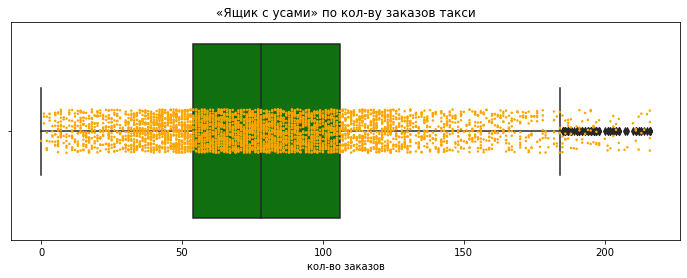

In [23]:
plt.figure(figsize=(12,4))
ax = sns.boxplot(x='num_orders', data=df, color="green")

ax = sns.stripplot(x='num_orders', data=df
                   , color="orange", jitter=1, size=2.5)
plt.title('«Ящик с усами» по кол-ву заказов такси')
plt.xlabel('кол-во заказов');

Удалим значения Nan.  
Разделим наш датасет на обучающую, валидационную и тестовую выборки, перемешивание использовать не будет, для теста отложим 10% данных.

In [24]:
df = df.dropna()
train, test = train_test_split(df, shuffle=False, test_size=0.2)
valid, test = train_test_split(test, shuffle=False, test_size=0.5)

Выделим целевой признак и обучающие признаки.

In [25]:
df

,num_orders,month,day,hour,dayofweek,lag_1,lag_2,lag_3,lag_4,rolling_mean,seasonal,trend,expanding_window,kurtosis,diff_4
datetime,,,,,,,,,,,,,,,
2018-03-01 23:00:00,58,3,1,23,3,113.0,66.0,61.0,45.0,71.25,25.060377,54.812500,56.833333,5.0,14.0
2018-03-02 00:00:00,90,3,2,0,4,58.0,113.0,66.0,61.0,74.50,60.287869,54.833333,58.160000,5.0,17.0
2018-03-02 01:00:00,120,3,2,1,4,90.0,58.0,113.0,66.0,81.75,20.221533,55.229167,60.538462,5.0,75.0
2018-03-02 02:00:00,75,3,2,2,4,120.0,90.0,58.0,113.0,95.25,28.902140,55.416667,61.074074,6.0,14.0
2018-03-02 03:00:00,64,3,2,3,4,75.0,120.0,90.0,58.0,85.75,17.836823,55.187500,61.178571,6.0,-2.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2018-08-31 18:00:00,207,8,31,18,4,217.0,197.0,116.0,133.0,165.75,-15.243285,165.958065,84.319655,7.0,71.0
2018-08-31 19:00:00,136,8,31,19,4,207.0,217.0,197.0,116.0,184.25,-7.269871,165.724967,84.331369,7.0,-30.0
2018-08-31 20:00:00,154,8,31,20,4,136.0,207.0,217.0,197.0,189.25,-2.767133,165.491869,84.347156,6.0,21.0


In [26]:
X_train = train.drop('num_orders', axis=1)
y_train = train['num_orders']
X_test = test.drop('num_orders', axis=1)
y_test = test['num_orders']
X_valid = valid.drop('num_orders', axis=1)
y_valid = valid['num_orders']

In [27]:
# проверим получившиеся выборки
X_train.shape, y_train.shape, X_valid.shape, y_valid.shape, X_test.shape, y_test.shape

((3472, 14), (3472,), (434, 14), (434,), (434, 14), (434,))

### Подбор гипперпараметров для моделей обучения и выбор модели

Для обучения возьмем три модели LGBM, CatBoost и линейную регрессию.

In [28]:
# в данные списки будем записывать полученные метрики и модели
rmse_valid = []
time_train = []
time_valid = []
model_name = []

random_state = 123456

In [29]:
# напишем функцию для расчета RMSE
def rmse_score(y, predict):
    rmse = mean_squared_error(y, predict, squared=False)
    return rmse

### CatBoost

Подберем параметры для CatBoost с помощью GridSearchCV.

In [30]:
# укажем параметры 
parametrs = { 'iterations': range(40, 200, 40),
              'learning_rate': [0.25],
              'random_seed': [random_state],
              'l2_leaf_reg': [15],
              'depth': range(4, 16, 4)
            }

In [31]:
%%time
start_time = time.time()

tscv = TimeSeriesSplit(n_splits=5)
model_cbr = CatBoostRegressor()
grid = GridSearchCV(model_cbr, parametrs, cv=tscv, scoring='neg_mean_squared_error')
grid.fit(X_train, y_train, verbose=40)

end_time = time.time()
time_trn = end_time - start_time

0:	learn: 26.8978886	total: 139ms	remaining: 5.41s
39:	learn: 9.6860098	total: 158ms	remaining: 0us
0:	learn: 25.7568441	total: 691us	remaining: 27ms
39:	learn: 10.2488643	total: 19.7ms	remaining: 0us
0:	learn: 26.7846746	total: 16ms	remaining: 623ms
39:	learn: 10.7821376	total: 36.3ms	remaining: 0us
0:	learn: 28.3759248	total: 743us	remaining: 29ms
39:	learn: 11.4561284	total: 23.5ms	remaining: 0us
0:	learn: 28.9590059	total: 16.1ms	remaining: 626ms
39:	learn: 11.8961268	total: 44ms	remaining: 0us
0:	learn: 26.8978886	total: 511us	remaining: 40.4ms
40:	learn: 9.5884776	total: 15.9ms	remaining: 15.1ms
79:	learn: 7.7242244	total: 30.4ms	remaining: 0us
0:	learn: 25.7568441	total: 16.7ms	remaining: 1.32s
40:	learn: 10.1838826	total: 35.9ms	remaining: 34.2ms
79:	learn: 8.9468981	total: 54.1ms	remaining: 0us
0:	learn: 26.7846746	total: 719us	remaining: 56.8ms
40:	learn: 10.6397740	total: 20.6ms	remaining: 19.6ms
79:	learn: 9.5550348	total: 39.5ms	remaining: 0us
0:	learn: 28.3759248	total: 7

In [32]:
# выведем лучшие параметры для нашей модели
grid.best_params_

{'depth': 4,
 'iterations': 160,
 'l2_leaf_reg': 15,
 'learning_rate': 0.25,
 'random_seed': 123456}

In [33]:
%%time
# обучим нашу модель с лучшими параметрами, чтобы замерить время обучения
start_time = time.time()

model_cbr = CatBoostRegressor(depth=4, iterations=160, l2_leaf_reg=15, learning_rate=0.25, random_seed=random_state)
model_cbr.fit(X_train, y_train, verbose=40, plot=True)

end_time = time.time()
time_trn = end_time - start_time

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	learn: 29.9583506	total: 1.43ms	remaining: 227ms
40:	learn: 12.4258643	total: 33.3ms	remaining: 96.5ms
80:	learn: 11.4586470	total: 59.2ms	remaining: 57.8ms
120:	learn: 10.6860863	total: 85.3ms	remaining: 27.5ms
159:	learn: 10.1091360	total: 111ms	remaining: 0us
CPU times: total: 1.47 s
Wall time: 159 ms


In [34]:
%%time
start_time = time.time()

predict_cbr = model_cbr.predict(X_valid)
rmse_cbr = rmse_score(y_valid, predict_cbr)

end_time = time.time()
time_tst = end_time - start_time

print('RMSE модели Catboost:', rmse_cbr)

RMSE модели Catboost: 17.298395608339654
CPU times: total: 0 ns
Wall time: 2 ms


In [35]:
rmse_valid.append(rmse_cbr)
time_train.append(time_trn)
time_valid.append(time_tst)
model_name.append(model_cbr.__class__.__name__)

По итогу с лучшими параметрами достигли RMSE 32.9 на валидационной выборке (требовалось не более 48), модель обучалась 1s.

### LightGBM

In [36]:
# создадим список с признаками
futures_name = list(X_train.columns)
futures_name

['month',
 'day',
 'hour',
 'dayofweek',
 'lag_1',
 'lag_2',
 'lag_3',
 'lag_4',
 'rolling_mean',
 'seasonal',
 'trend',
 'expanding_window',
 'kurtosis',
 'diff_4']

In [37]:
%%time
start_time = time.time()

df_train_lgb = lgb.Dataset(X_train, label = y_train, feature_name = futures_name)

param = {'learning_rate':0.1, 'n_estimators':1200, 'objective':'root_mean_squared_error'}

num_round = 1000
model_lgb = lgb.train(param, df_train_lgb, num_round)

end_time = time.time()
time_trn = end_time - start_time

[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000312 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1772
[LightGBM] [Info] Number of data points in the train set: 3472, number of used features: 14
[LightGBM] [Info] Start training from score 73.830933


C:\Users\ХАА\AppData\Roaming\Python\Python39\site-packages\lightgbm\engine.py:177: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


CPU times: total: 5.8 s
Wall time: 482 ms


In [38]:
%%time
start_time = time.time()

predict_lgb = model_lgb.predict(X_valid)
rmse_lgb = rmse_score(y_valid, predict_lgb)

end_time = time.time()
time_tst = end_time - start_time
print('RMSE модели LGBM', rmse_lgb)

RMSE модели LGBM 17.657707514902217
CPU times: total: 141 ms
Wall time: 8.14 ms


In [39]:
rmse_valid.append(rmse_lgb)
time_train.append(time_trn)
time_valid.append(time_tst)
model_name.append('LightGBM')

### LinearRegression

In [40]:
%%time
start_time = time.time()

model_lnr = LinearRegression()
model_lnr.fit(X_train, y_train)

end_time = time.time()
time_trn = end_time - start_time

CPU times: total: 0 ns
Wall time: 13.5 ms


In [41]:
%%time
start_time = time.time()

predict_lnr = model_lnr.predict(X_valid)
rmse_lnr = rmse_score(y_valid, predict_lnr)

end_time = time.time()
time_tst = end_time - start_time

print('RMSE модели LinearRegression:', rmse_lnr)

RMSE модели LinearRegression: 21.463716645780565
CPU times: total: 125 ms
Wall time: 2.03 ms


In [42]:
rmse_valid

[17.298395608339654, 17.657707514902217]

In [43]:
rmse_valid.append(rmse_lnr)
time_train.append(time_trn)
time_valid.append(time_tst)
model_name.append('LinearRegression')

### Анализ моделей

По каждой модели мы сохранили три метрики, преобразуем наши списки в датафрейм.

In [44]:
stat = pd.DataFrame({'model_name': model_name, 'time_train, sec': time_train,
      'time_valid, sec': time_valid , 'rmse_valid': rmse_valid}
    ).sort_values(by='rmse_valid').reset_index(drop=True)
stat['total_time'] = stat['time_valid, sec'] + stat['time_train, sec']
# выделим лучшие значения
(
    stat.style.highlight_min(['rmse_valid', 'time_train, sec', 'time_valid, sec', 'total_time'], color='green', axis = 0)
)

,model_name,"time_train, sec","time_valid, sec",rmse_valid,total_time
0,CatBoostRegressor,0.158742,0.002000,17.298396,0.160742
1,LightGBM,0.482380,0.008145,17.657708,0.490525
2,LinearRegression,0.013489,0.002032,21.463717,0.015521


Самые лучшие результаты по скорости обучения и предсказаний у модели LinearRegression, но с самым худшим RMSE. RMSE лучше у CatBoostRegressor и по общему времени данная модель занимает 2 место. 
Проверим важность признаков на двух моделях CatBoostRegressor и LightGBM.

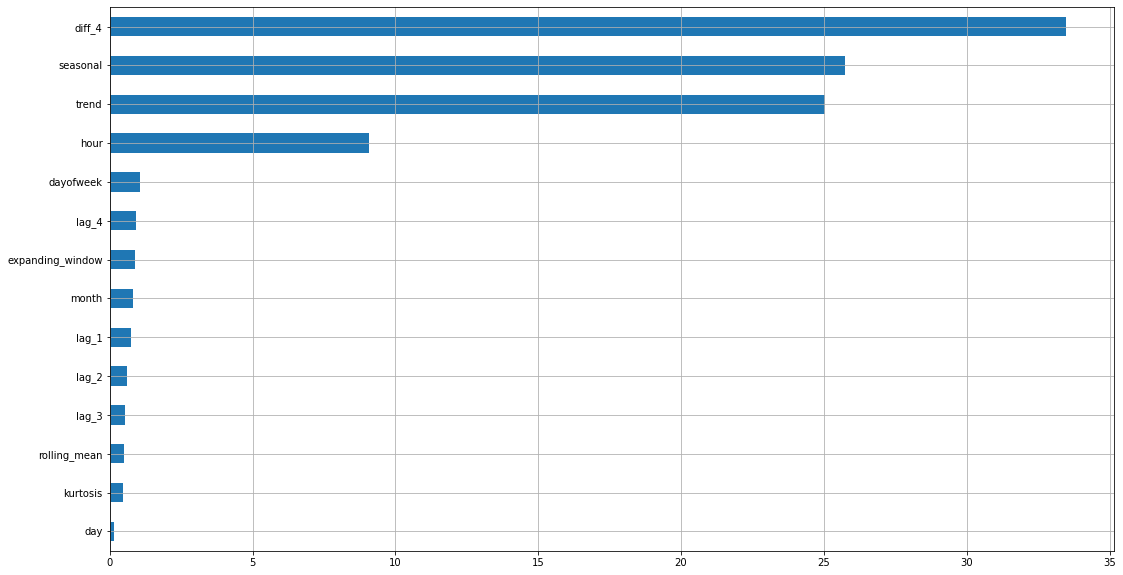

In [45]:
# важность признаков CatBoostRegressor
(pd.DataFrame(data={'score': model_cbr.feature_importances_}, 
                      index=X_train.columns).sort_values(by='score')
                                         .plot(kind='barh', grid=True,
                                               figsize=(18,10), legend=False))
plt.show;

Для модели CatBoostRegressor самым важным признаком оказался час, в который были созданы заказы.

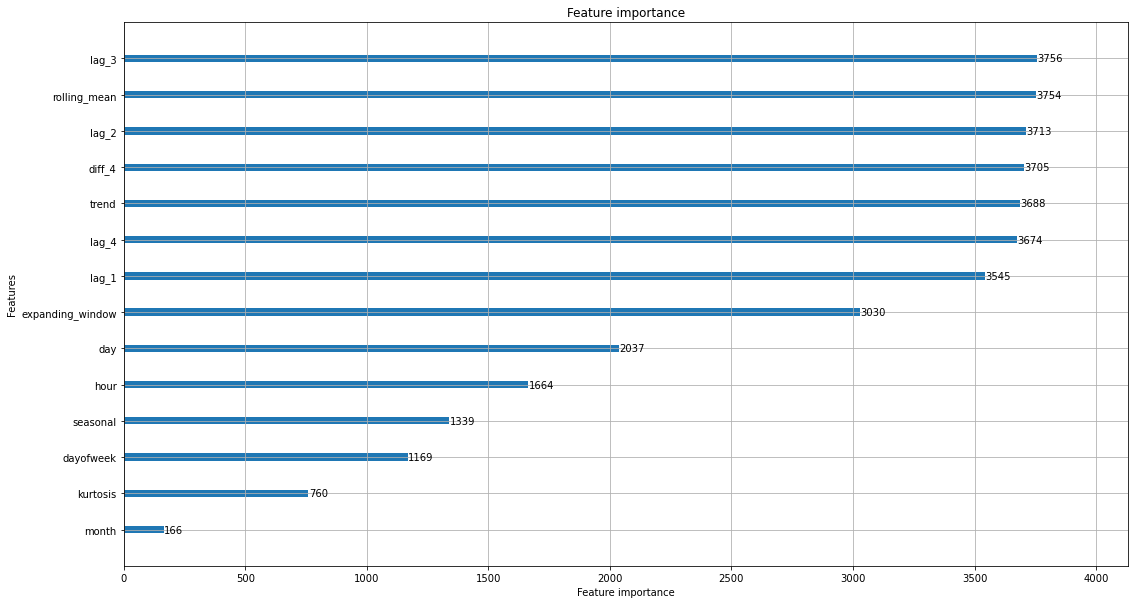

In [46]:
# важность признаков LightGBM
lgb.plot_importance(model_lgb, figsize = (18, 10))
plt.show()

Для модели LightGBM самым важным признаком является скользящее среднее, далее идут наши созданные признаки.

Таким образом для обеих моделей имеем два разных важных признака. Исходя из всех параметров рекомендуем CatBoostRegressor, по качеству и по скорости он быстрее.

## Тестирование

Протестируем выбранную модель.

In [47]:
%%time
# обучим нашу модель с лучшими параметрами еще раз
start_time = time.time()

model_cbr = CatBoostRegressor(depth=4, iterations=160, l2_leaf_reg=15, learning_rate=0.25, random_seed=random_state)
model_cbr.fit(X_train, y_train, verbose=40, plot=True)

end_time = time.time()
time_trn = end_time - start_time

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	learn: 29.9583506	total: 8.09ms	remaining: 1.28s
40:	learn: 12.4258643	total: 36.5ms	remaining: 106ms
80:	learn: 11.4586470	total: 65.5ms	remaining: 63.9ms
120:	learn: 10.6860863	total: 93.8ms	remaining: 30.2ms
159:	learn: 10.1091360	total: 121ms	remaining: 0us
CPU times: total: 1.39 s
Wall time: 162 ms


In [48]:
%%time
start_time = time.time()

predict_cbr = model_cbr.predict(X_test)
rmse_cbr = rmse_score(y_test, predict_cbr)

end_time = time.time()
time_tst = end_time - start_time

print('RMSE модели Catboost:', rmse_cbr)
print('Время теста модели Catboost:', time_tst)

RMSE модели Catboost: 31.758850097495518
Время теста модели Catboost: 0.0020003318786621094
CPU times: total: 0 ns
Wall time: 2 ms


Построим ряды в виде графика для сравнения настоящих значений и предсказанных.

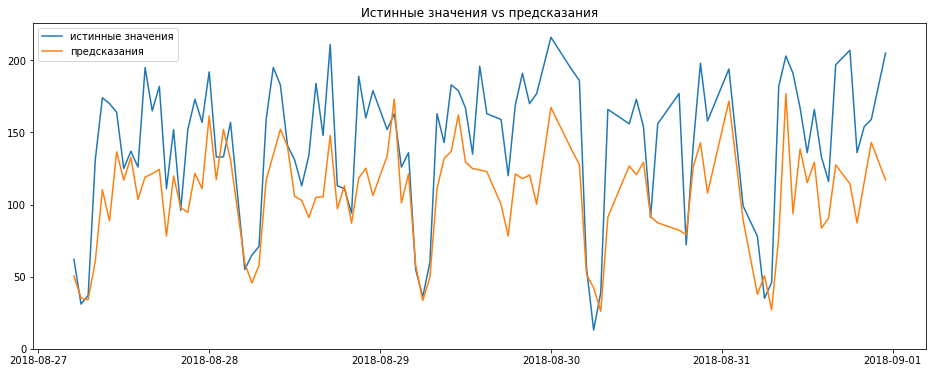

In [49]:
plt.figure(figsize=(16,6))
plt.plot(y_test.index[-100:], y_test[-100:], label='истинные значения')
plt.plot(y_test.index[-100:], predict_cbr[-100:], label='предсказания')
plt.title('Истинные значения vs предсказания')
plt.legend()
plt.ylim(0)
plt.show()

## Вывод

1. В нашем распоряжении 26496 записей. Данные с 2018-03-01 по 2018-08-31 за каждые 10 минут. Выполнили ресемплирование по одному часу.
2. Есть сезонность связанная со веременем суток, проверили разницу ряда, она стационарная, данные можно прогнозировать.
3. Самые лучшие результаты по скорости обучения и предсказаний у модели LinearRegression, но с самым худшим RMSE. RMSE лучше у CatBoostRegressor и по общему времени данная модель занимает 2 место. Проверим важность признаков на двух моделях CatBoostRegressor и LightGBM.
4. Для модели CatBoostRegressor самым важным признаком оказался час, в который были созданы заказы. Для модели LightGBM самым важным признаком является скользящее среднее, далее идут наши созданные признаки. Таким образом для обеих моделей имеем два разных важных признака. 
5. Исходя из всех параметров рекомендуем CatBoostRegressor, по качеству и по скорости он быстрее.
6. Провели тестирование выбранной модели RMSE 42.9, ниже порогового.